In [2]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as optimize
import scipy.special as special
from time import time

 Denne kode fortæller os vat det virker rigtig godt for k > 0.01 men for k mindre end det er det lidt skidt

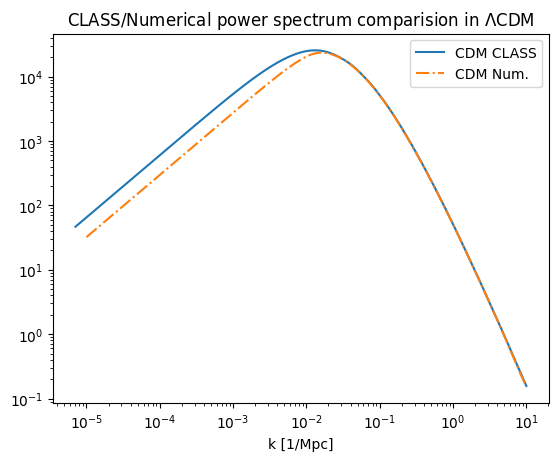

In [5]:
def TEST(kvec=list(np.logspace(-5,1,20)),kind=0,z=800,mv_test=1,
         Omega_M = 0.31,Omega_b=0.01,
         PLOT_FIGUR=True,div_med_a=False,
         EdSitter=True,interpolation_type="cubic"):
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    kvalg = kvec[kind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 #,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl,mPk', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    
    tid = bg['proper time [Gyr]'] * c / 306.4 # det kommer af Gyrs * c = 306.4 Mpc
    
    pts = cosmo.get_perturbations()['scalar']
    
    tranf = cosmo.get_transfer(z=0) 
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    k_sup = tranf['k (h/Mpc)'] * h
    
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"],kind=interpolation_type)
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],
                                             prim["P_scalar(k)"],
                                             fill_value="extrapolate",
                                             kind=interpolation_type)
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
        
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)

    D = np.empty(len(kvec))
    
    for kind,kvalue in enumerate(kvec[::-1]):

        delta_class = pts[kind]["delta_cdm"]
        theta_class = pts[kind]["theta_cdm"]
        tau_class = pts[kind]["tau [Mpc]"]
        a_class = pts[kind]["a"]
        interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class,kind=interpolation_type)
        delta_interp = scipy.interpolate.interp1d(tau_class,delta_class,kind=interpolation_type)
        theta_interp =scipy.interpolate.interp1d(tau_class,delta_class,kind=interpolation_type)
        a_interp = scipy.interpolate.interp1d(tau_class,a_class,kind=interpolation_type)
        a0 = 1/(1+z)
        a_span = [a0,1]
        T0 = float(interp_tau_from_a(a0))
        delta0 = delta_interp(T0)
        t0 = tau_class[-1]
        tspan = [T0,t0]
        t = np.logspace(np.log10(T0),np.log10(t0),100)
        # hypotese, problemet er da at P(K) =er afhængig af d^1(k)^2 ikke d^2(k)^2 som er hvad jeg har plottet.
        def Dfunc(tau,y):
            a = a_interp(tau)
            D = y[0]
            dD = y[1]
            d2D = - H(a) * dD + (3/2) * H0*H0 * Omega_M * D / a
            return [dD,d2D]
        delta_diff = lambda t,h: (delta_interp(t+h)-delta_interp(t))/h
        start0 = [delta_interp(T0),delta_diff(T0,1)]
        sol = scipy.integrate.solve_ivp(Dfunc, t_span = tspan, y0 = start0)
        D[kind] = sol.y[0][-1]
        
    Dp = scipy.interpolate.interp1d(kvec,D,kind=interpolation_type)
    
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    pD = lambda k: 2*np.pi**2 * Dp(k)** 2 *  prim_interp(k) * h**3  *k**(-3)
    
    plt.figure(np.random.randint(1,11231123))
    plt.title("Power spectrum plot to see the difference between \nclass transfer functions And my own simulation.")
    plt.title("CLASS/Numerical power spectrum comparision in $\Lambda$CDM")
    plt.loglog(k,p(k),label="CDM CLASS")
    kvec = np.array(kvec)
    kx = np.logspace(np.log10(kvec[0]),np.log10(kvec[-1]),1000)
    plt.loglog(kx,pD(kx),"-.",label="CDM Num.")
    plt.xlabel("k [1/Mpc]")
    plt.legend()
    plt.savefig("power_spectrum_cdm_EdS.png")
    Class.struct_cleanup
TEST()

